In [1]:
import cvxpy as cp
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import casadi as ca

from __future__ import annotations
import math
from typing import Tuple, List

In [107]:
def fluid_value(T, N, lam, y0, steady_state = False, steady_control = False):
    b = (N+ np.sqrt(lam))**3
    
    u = ca.MX.sym('u', T)
    y = ca.MX.sym('y', T+1)
    
    # objective

    J = 0
    for t in range(T):
        J += (N*1/(1-u[t]) + 1)*y[t]**2 #-b
    J = (J) #+ y[T]

    # constraints list
    g = []
    # initial condition
    g.append(y[0] - y0)
    # dynamics
    if steady_state:
        for t in range(T):
            g.append(y[t+1] - y[t])
    else:    
        for t in range(T):
            g.append(y[t+1] - (y[t] + lam - u[t]*y[t]))
            
    # pack into NLP
    w   = ca.vertcat(u, y)
    nlp = {'x': w, 'f': J, 'g': ca.vertcat(*g)}
    opts = {'ipopt.print_level': 0, 'print_time': 0}
    solver = ca.nlpsol('S', 'ipopt', nlp, opts)

    # bounds
    lbg = [0]*len(g)         # dynamics = 0, init = 0
    ubg = [0]*len(g)
    if steady_control:
        u_fix = np.sqrt(lam)/(N+np.sqrt(lam))
        lbx = [u_fix]*T     + [0]*(T+1) 
        ubx = [u_fix]*T     + [1e6]*(T+1)
    else:
        lbx = [0]*T + [0]*(T+1)  # u >= 0, y >= 0
        ubx = [1]*T + [1e6]*(T+1)
    
    # solve
    res = solver(lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg)
    w_opt = res['x'].full().flatten()
    u_opt = w_opt[:T]
    y_opt = w_opt[T:]
    return float(res['f']), u_opt, y_opt

def fluid_array(T, N, lam_values, upper_bound_capacity):
    #Solve the deterministic version of the multi-secretary problem for all periods in approx_periods and all capacities
    capacities = np.arange(0, upper_bound_capacity + 1, 1)
    val_deterministic = np.zeros((len(lam_values), capacities.shape[0]))
    solution_deterministic = np.zeros((len(lam_values), capacities.shape[0], T))
    states_deterministic = np.zeros((len(lam_values), capacities.shape[0], T+1))
    for indx, lam in enumerate(lam_values):
        for indx_cap, x in tqdm(enumerate(capacities)):
            val_deterministic[indx, indx_cap], solution_deterministic[indx, indx_cap, :], states_deterministic[indx, indx_cap, :] = fluid_value(T, N, lam, x)
            
    return val_deterministic, solution_deterministic, states_deterministic


################################################################################
# Utility: binomial coefficient tables
################################################################################

def build_binom_tables(S_max: int) -> List[List[int]]:
    """Return a triangular table C[n][k] = binom(n,k) for n≤S_max."""
    C = [[1]]
    for n in range(1, S_max + 1):
        row = [1]
        for k in range(1, n):
            row.append(C[n - 1][k - 1] + C[n - 1][k])
        row.append(1)
        C.append(row)
    return C

################################################################################
# Golden‑section search on [a,b]
################################################################################

def golden_section_minimize(f, a: float, b: float, tol: float = 1e-9, max_it: int = 100) -> Tuple[float, float]:
    """Minimise *unimodal* f on [a,b] via golden‑section search.

    Returns `(argmin, f(argmin))`."""
    phi = (1 + 5 ** 0.5) / 2  # golden ratio φ≈1.618
    invphi = 1 / phi          # 1/φ≈0.618

    c = b - invphi * (b - a)
    d = a + invphi * (b - a)
    fc = f(c)
    fd = f(d)

    for _ in range(max_it):
        if abs(b - a) < tol:
            break
        if fc < fd:
            b, d, fd = d, c, fc
            c = b - invphi * (b - a)
            fc = f(c)
        else:
            a, c, fc = c, d, fd
            d = a + invphi * (b - a)
            fd = f(d)
    u_star = 0.5 * (a + b)
    return u_star, f(u_star)

################################################################################
# value iteration with *continuous* control + history
################################################################################

def value_iteration(
    lam: float,
    N: float,
    S_max: int,
    tol: float = 1e-8,
    max_iter: int = 20_000,
    ref_state: int | None = 0,
    val_initial: np.ndarray | None = None
) -> Tuple[np.ndarray, float, np.ndarray, int, List[float], List[np.ndarray], np.ndarray]:
    """Differential cost iteration (continuous control) **with history**.

    Returns `u_star, g, h, it, g_hist, h_hist` where:
    * `g_hist[k]   = g_k` average‑cost estimate at iteration *k*;
    * `h_hist[k]   = h_k` differential cost **vector** at iteration *k*.
    """
    if not (0 < lam < 1):
        raise ValueError("λ must be in (0,1).")
    if ref_state is None:
        ref_state = 0

    S = S_max + 1
    value = val_initial if val_initial is not None else np.zeros(S)  # initial value function
    u_star = np.zeros(S)
    g = value[ref_state]/1000   # average cost
    h = value - value[ref_state]  # differential cost vector
    # --- history containers ---
    g_hist: List[float] = []
    h_hist: List[np.ndarray] = []

    # Pre‑compute binomial coefficients
    Cnk = build_binom_tables(S_max)
    eps_u = 1e-10  # guard against u→1

    value_temp = np.zeros(S)


    for it in range(1, max_iter + 1):
        value_new = np.zeros(S)  # new differential cost vector

        # ----- Bellman minimisation over u ∈ [0,1) for each x -----
        for x in range(S):
            def Q(u: float) -> float:
                one_minus_u = 1.0 - u
                inv_one_minus_u = N * 1 / one_minus_u  # part of cost plus exp terms

                # Expected continuation cost
                pow_u = 1.0  # u^d incrementally
                exp_val = 0.0
                for d in range(x + 1):
                    if d > 0:
                        pow_u *= u
                    prob = Cnk[x][d] * pow_u * (one_minus_u ** (x - d))
                    idx_arr1 = min(x + 1 - d, S_max)  # arrival=1
                    idx_arr0 = x - d                  # arrival=0
                    exp_val += prob * (lam * value[idx_arr1] + (1 - lam) * value[idx_arr0])
                return (inv_one_minus_u + 1)*x**2  + exp_val

            u_opt, q_val = golden_section_minimize(Q, 0.0, 1.0 - eps_u)
            u_star[x] = u_opt
            value_new[x] = q_val

        # ----- Average‑cost update and normalisation -----
        g_new = value_new[ref_state] - value[ref_state]
        h_new = value_new - value_new[ref_state]
        # ----- Save history -----
        g_hist.append(g_new)
        h_hist.append(h_new.copy())
        if it == 20:
            value_temp = np.array(value_new) 
            

        # ----- Convergence test -----
        if max(abs(g_new - g), np.max(np.abs(h_new - h)))  < tol:
            g = g_new
            break
        value = value_new
        g = g_new
        h = h_new
    else:
        it = max_iter

    return u_star, g, h, it, g_hist, h_hist, value_new, value_temp

In [88]:
T = 500
N = 1
lam_values = .5 
upper_bound_capacity = 100

lam = lam_values
print('stable cost: '+ str((N+ np.sqrt(lam))**3))
print('stable policy: '+ str(lam**(2/3)/(N+lam**(2/3))))
print('steady state: '+ str(lam**(1/3)*(N+lam**(2/3))))

stable cost: 4.974873734152916
stable policy: 0.38648820956430935
steady state: 1.2937005259841


In [89]:
stable_state = np.sqrt(lam_values)*(N+np.sqrt(lam_values))
#capacities = np.array([stable_state])
capacities = np.arange(0, upper_bound_capacity + 1, 1)
val_fluid = np.zeros((capacities.shape[0]))
solution_fluid = np.zeros((capacities.shape[0], T))
states_fluid = np.zeros((capacities.shape[0], T+1))
val_steady_control = np.zeros((capacities.shape[0]))
solution_steady_control = np.zeros((capacities.shape[0], T))
states_steady_control = np.zeros((capacities.shape[0], T+1))

for indx_cap, x in tqdm(enumerate(capacities)):
    val_fluid[indx_cap], solution_fluid[indx_cap, :], states_fluid[indx_cap, : ] = fluid_value(T, N, lam_values, x)
    val_steady_control[indx_cap], solution_steady_control[indx_cap, :], states_steady_control[indx_cap, : ] = fluid_value(T, N, lam_values, x, steady_control=True)

print("Fluid value:", val_fluid)

101it [00:40,  2.52it/s]

Fluid value: [ 1096.93989735  1103.78511668  1119.36173605  1143.09116179
  1174.8913774   1214.73280282  1262.6012719   1318.48887486
  1382.39073796  1454.30364294  1534.22535227  1622.15424692
  1718.08911734  1822.02903599  1933.97327591  2053.92125674
  2181.87250776  2317.82664188  2461.78333695  2613.74232197
  2773.70336681  2941.6662744   3117.63087465  3301.59701978
  3493.56458054  3693.53344327  3901.50350745  4117.4746838
  4341.44689261  4573.42006247  4813.39412912  5061.36903452
  5317.34472613  5581.32115616  5853.29828107  6133.27606106
  6421.25445964  6717.23344329  7021.21298117  7333.19304478
  7653.17360778  7981.15464577  8317.13613608  8661.11805763
  9013.10039078  9373.08311721  9741.06621979 10117.04968248
 10501.03349025 10893.01762899 11293.00208545 11700.98684715
 12116.97190232 12540.95723988 12972.94284935 13412.92872083
 13860.91484495 14316.90121283 14780.88781605 15252.87464663
 15732.86169698 16220.84895988 16716.83642847 17220.82409621
 17732.81195

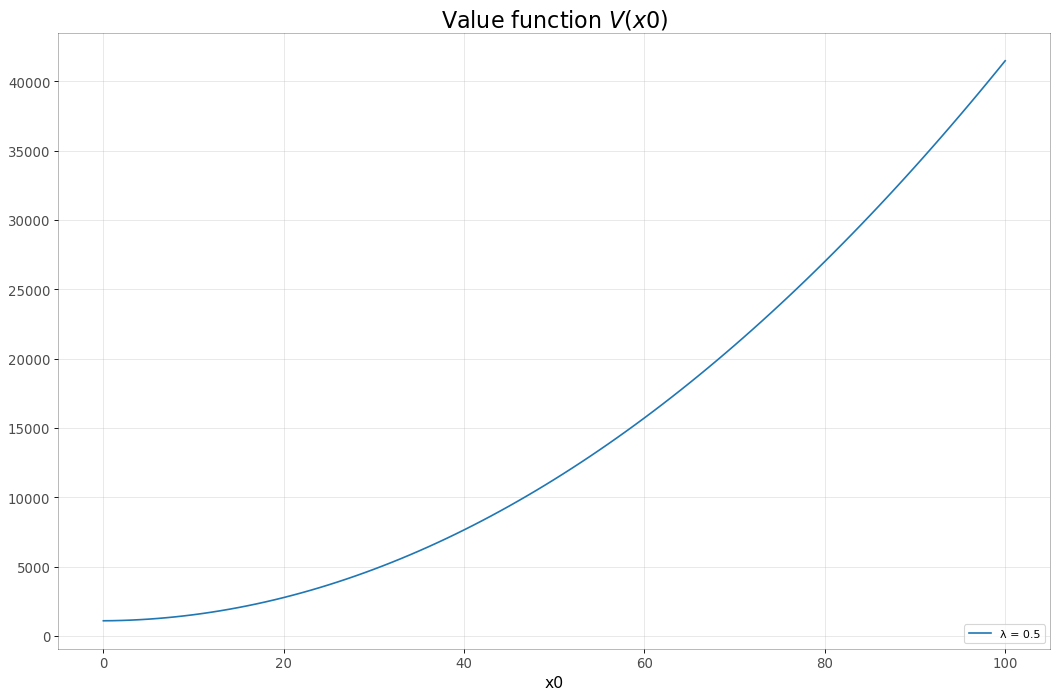

In [90]:
line_styles = itertools.cycle(['-', '--', '-.', ':'])
colors = itertools.cycle(['black', 'red', 'blue'])
plt.figure(figsize=(16,10), dpi= 80)
x=np.arange(0, upper_bound_capacity + 1, 1)
plt.plot(x, val_fluid, label=f'λ = {lam_values}', linestyle=next(line_styles), marker='', fillstyle='none')
# Decoration
plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title('Value function $V(x0)$', fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.xlabel('x0', fontsize = 14)
plt.gca().spines["top"].set_alpha(0.3)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.legend(loc = "lower right")
plt.show()
plt.close()

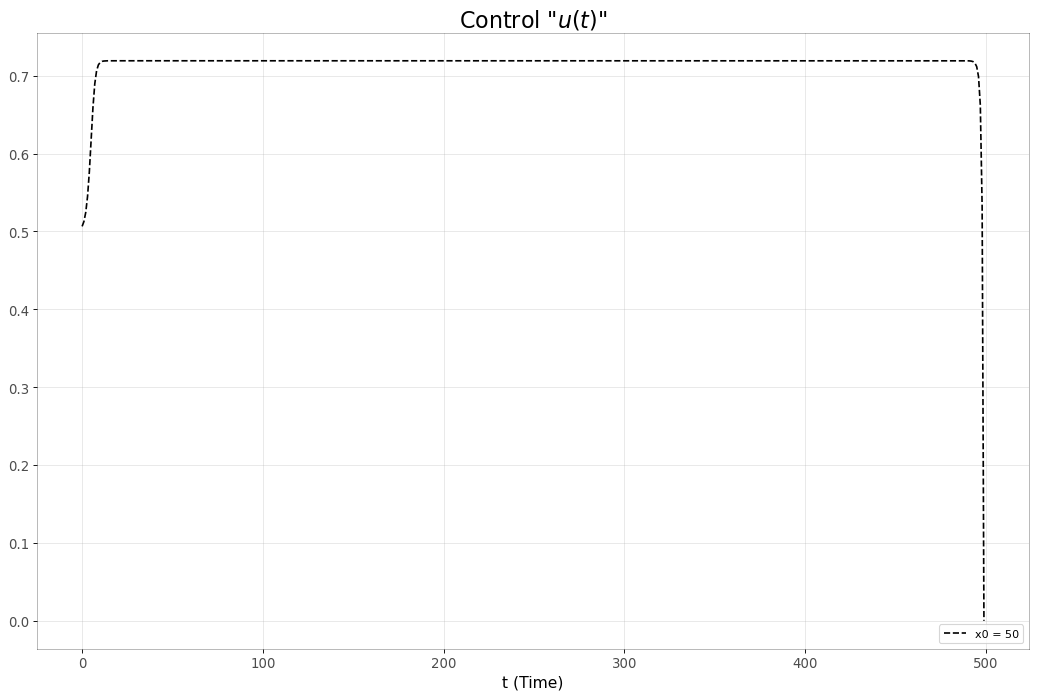

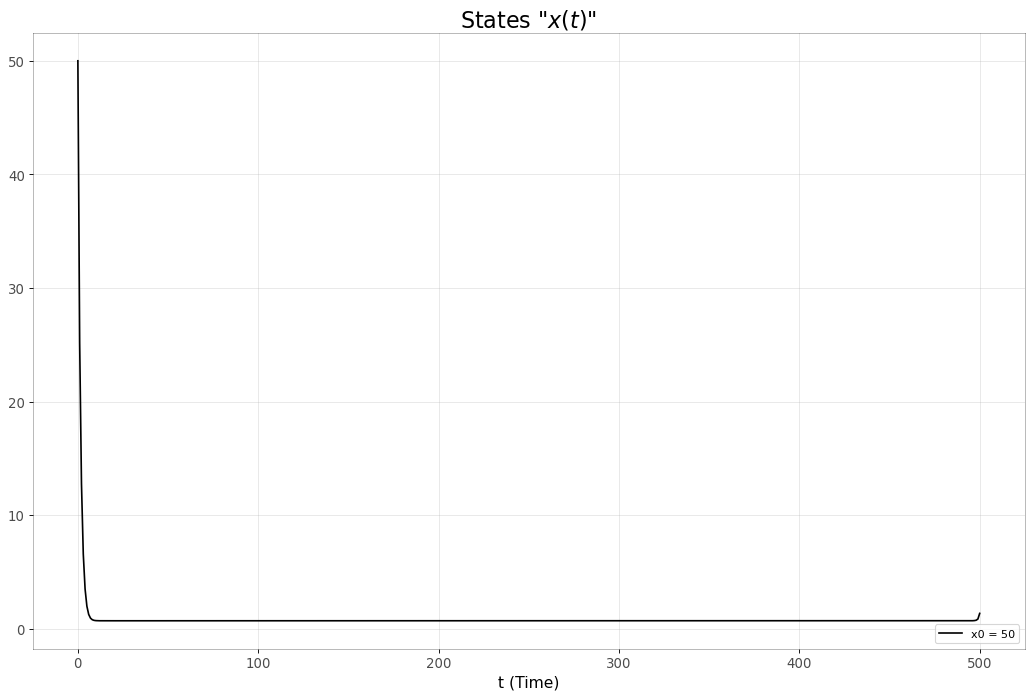

In [91]:
initial_state = 50
line_styles = itertools.cycle(['--', '-.', ':'])
colors = itertools.cycle(['black', 'red', 'blue'])
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(solution_fluid[initial_state][:], label=f'x0 = {initial_state}', linestyle=next(line_styles), marker='', fillstyle='none', color=next(colors))
#plt.plot(solution_steady_control[0][:50], label=f'Steady Control u = sqrt(lam)/N', linestyle=next(line_styles), marker='', fillstyle='none', color=next(colors))
plt.xlabel('t (Time)', fontsize = 14)
# Decoration
plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title('Control "$u(t)$"', fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.gca().spines["top"].set_alpha(0.3)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.legend(loc = "lower right")
plt.show()

line_styles = itertools.cycle(['-', '--', '-.', ':'])
colors = itertools.cycle(['black', 'red', 'blue'])
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(states_fluid[initial_state][:], label=f'x0 = {initial_state}', linestyle=next(line_styles), marker='', fillstyle='none', color=next(colors))
#plt.plot(states_steady_control[0][:50], label=f'Steady Control u = sqrt(lam)/N', linestyle=next(line_styles), marker='', fillstyle='none', color=next(colors))
plt.xlabel('t (Time)', fontsize = 14)
# Decoration
plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title('States "$x(t)$"', fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.gca().spines["top"].set_alpha(0.3)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.legend(loc = "lower right")
plt.show()

=== Continuous‑control Geom/Geom/∞ queue ===
Arrival probability λ    : 0.5
Optimal average cost g*  : 4.061207
Iterations to converge   : 13

Optimal control u*(x) for x=0..20:
[1.     0.7192 0.6439 0.607  0.5852 0.5708 0.5606 0.5529 0.547  0.5422
 0.5384 0.5351 0.5324 0.5301 0.528  0.5263 0.5247 0.5233 0.5221 0.521
 0.52   0.5191 0.5182 0.5175 0.5168 0.5161 0.5155 0.515  0.5144 0.514
 0.5135 0.5131 0.5127 0.5123 0.512  0.5116 0.5113 0.511  0.5107 0.5105
 0.5102 0.51   0.5097 0.5095 0.5093 0.5091 0.5089 0.5087 0.5085 0.5084
 0.5082 0.508  0.5079 0.5077 0.5076 0.5075 0.5073 0.5072 0.5071 0.507
 0.5068 0.5067 0.5066 0.5065 0.5064 0.5063 0.5062 0.5061 0.5061 0.506
 0.5059 0.5058 0.5057 0.5056 0.5056 0.5055 0.5054 0.5054 0.5053 0.5052
 0.5052 0.5051 0.505  0.505  0.5049 0.5049 0.5048 0.5047 0.5047 0.5046
 0.5046 0.5045 0.5045 0.5044 0.5044 0.5043 0.5043 0.5043 0.5042 0.5042
 0.5041]
Optimal average cost g* (fluid value)  : 4.061235
Iterations to converge (fluid value)   : 10

Optimal cont

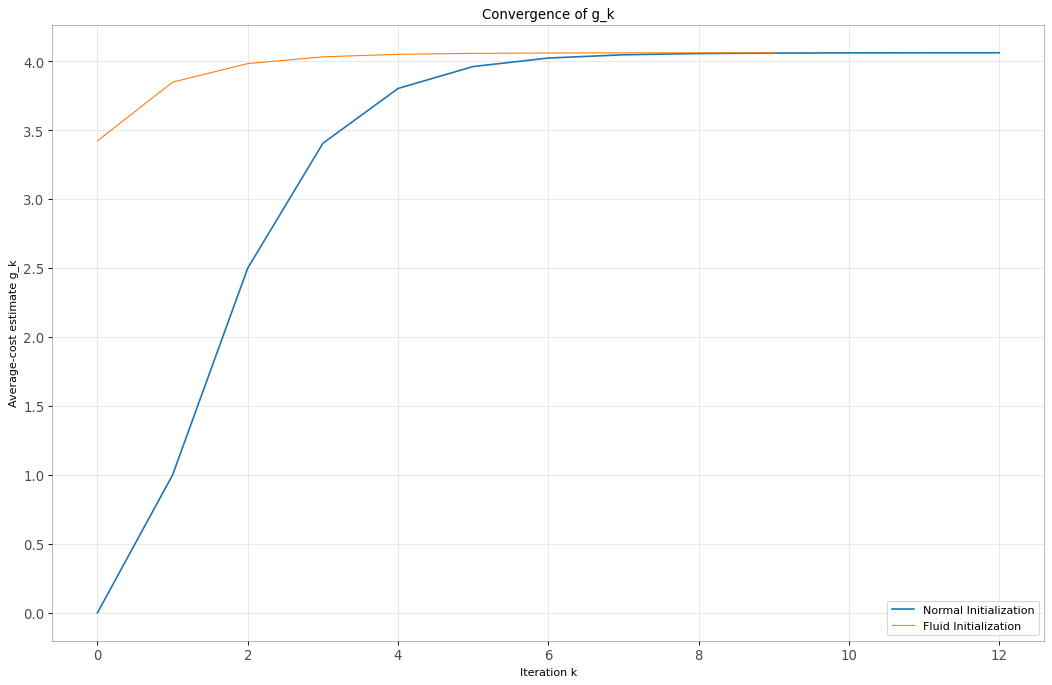

In [ ]:
lam = lam_values
S_max = upper_bound_capacity
initial_fluid_array = val_fluid #- val_fluid[0]  # relative to the first capacity
stupid_initial = np.zeros(S_max+1)#np.array([-i**2 for i in range(S_max + 1)])  # 
results = value_iteration(lam, N, S_max, ref_state=0, tol=1e-1, max_iter=1000, val_initial=stupid_initial)
u_policy, g_star, h_star, n_it, g_hist, h_hist, value, value_temp = results
results_fluid = value_iteration(lam, N, S_max, ref_state=0, tol=1e-1, max_iter=1000, val_initial=initial_fluid_array)
u_policy_fluid, g_star_fluid, h_star_fluid, n_it_fluid, g_hist_fluid, h_hist_fluid, value_fluid, value_temp_fluid = results_fluid

print("=== Continuous‑control Geom/Geom/∞ queue ===")
print(f"Arrival probability λ    : {lam}")
print(f"Optimal average cost g*  : {g_star:.6f}")
print(f"Iterations to converge   : {n_it}")
print("\nOptimal control u*(x) for x=0..20:")
print(np.round(u_policy[:], 4))

print(f"Optimal average cost g* (fluid value)  : {g_star_fluid:.6f}")
print(f"Iterations to converge (fluid value)   : {n_it_fluid}")
print("\nOptimal control u*(x) for x=0..20 (fluid value):")
print(np.round(u_policy_fluid[:], 4))

# ---------- Plot convergence of g_k ----------
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(g_hist[:], marker="", fillstyle='none', label ='Normal Initialization')
plt.plot(g_hist_fluid[:], marker="", linewidth=1, label='Fluid Initialization')
plt.xlabel("Iteration k")
plt.ylabel("Average‑cost estimate g_k")
plt.title("Convergence of g_k")
plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.grid(axis='both', alpha=.3)
plt.gca().spines["top"].set_alpha(0.3)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.legend(loc = "lower right")
plt.show()

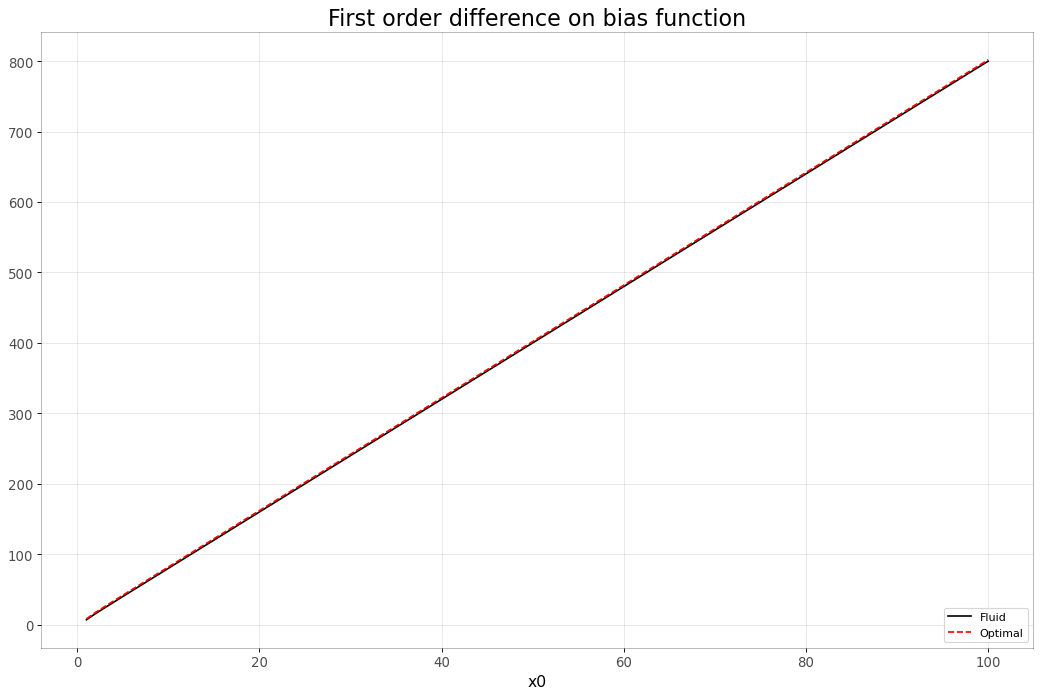

In [93]:
optimal_value = np.array(value)

line_styles = itertools.cycle(['-', '--', '-.', ':'])
colors = itertools.cycle(['black', 'red', 'blue'])
plt.figure(figsize=(16,10), dpi= 80)
x=np.arange(0, upper_bound_capacity + 1, 1)
plt.plot(x[1:], val_fluid[1:]-val_fluid[:-1], label='Fluid', linestyle=next(line_styles), marker='', fillstyle='none', color = next(colors))
plt.plot(x[1:], optimal_value[1:] - optimal_value[:-1], label='Optimal', linestyle=next(line_styles), marker='', fillstyle='none', color = next(colors))
#plt.plot(x[1:], value_temp_fluid[1:] - value_temp_fluid[:-1], label='Fluid Jumps', linestyle=next(line_styles), marker='', fillstyle='none', color = next(colors))

# Decoration
plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title('First order difference on bias function', fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.xlabel('x0', fontsize = 14)
plt.gca().spines["top"].set_alpha(0.3)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.legend(loc = "lower right")
plt.show()
plt.close()

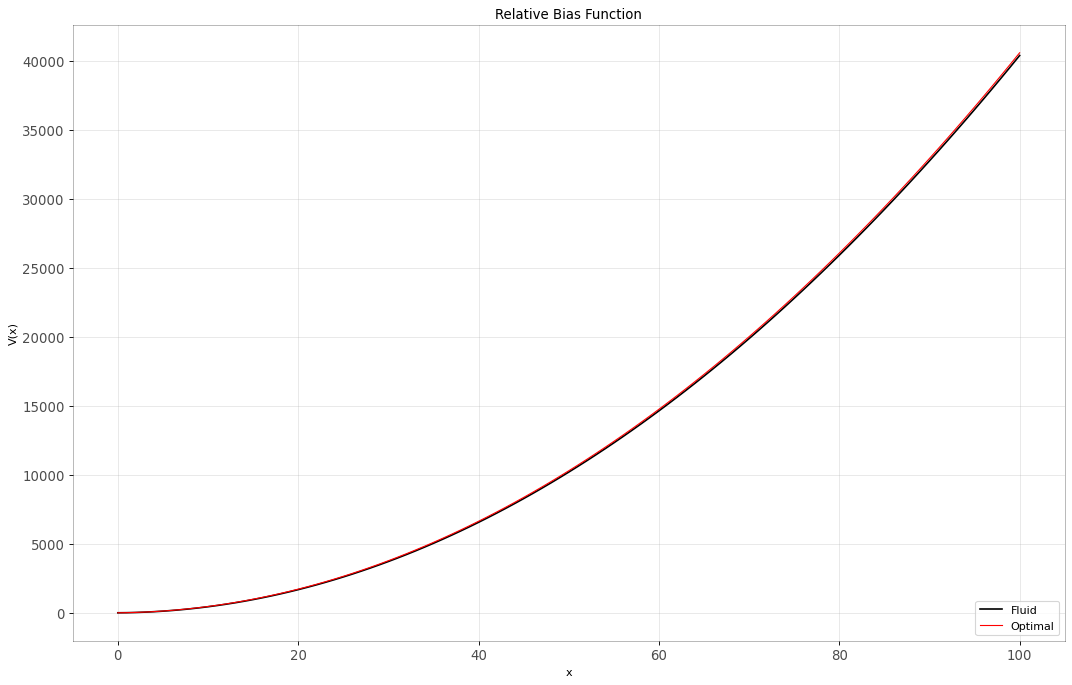

In [94]:
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(val_fluid[:] - val_fluid[0], marker="", fillstyle='none', label ='Fluid', color = 'black')
plt.plot(h_star_fluid[:], marker="", linewidth=1, label='Optimal', color = 'red')
#plt.plot(h_star[:], marker="", linewidth=1, label='Optimal value from 0', color = 'blue')
plt.xlabel("x")
plt.ylabel("V(x)")
plt.title("Relative Bias Function")
plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.grid(axis='both', alpha=.3)
plt.gca().spines["top"].set_alpha(0.3)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.legend(loc = "lower right")
plt.show()

In [108]:
T= 1000
lam = .5 
S_max = 100
capacities = np.arange(0, S_max + 1, 1)
N_values = np.array([1, 2, 5, 10, 20, 50, 100]) #np.arange(10, 201, 10)
n_it_fluid = np.zeros((N_values.shape[0]))
n_it = np.zeros((N_values.shape[0]))    

for index, N in tqdm(enumerate(N_values)):
    T = (N * 20)
    val_fluid = np.zeros((capacities.shape[0]))
    solution_fluid = np.zeros((capacities.shape[0], T))
    states_fluid = np.zeros((capacities.shape[0], T+1))
    for indx_cap, x in enumerate(capacities):
        val_fluid[indx_cap], solution_fluid[indx_cap, :], states_fluid[indx_cap, : ] = fluid_value(T, N, lam, x)

    initial_fluid_array = val_fluid + N*(N+ np.sqrt(lam))+ np.sqrt(lam)*(N+np.sqrt(lam))
    stupid_initial = np.zeros(S_max+1)#np.array([-i**2 for i in range(S_max + 1)])  # 
    results = value_iteration(lam, N, S_max, ref_state=0, tol=1e-3, max_iter=1000, val_initial=stupid_initial)
    u_policy, g_star, h_star, n_it[index], g_hist, h_hist, value, value_temp = results
    results_fluid = value_iteration(lam, N, S_max, ref_state=0, tol=1e-3, max_iter=1000, val_initial=initial_fluid_array)
    u_policy_fluid, g_star_fluid, h_star_fluid, n_it_fluid[index], g_hist_fluid, h_hist_fluid, value_fluid, value_temp_fluid = results_fluid

7it [03:38, 31.18s/it]


In [109]:
print(n_it)
print(n_it_fluid)

[18. 20. 23. 24. 25. 27. 27.]
[15. 17. 19. 20. 21. 22. 23.]


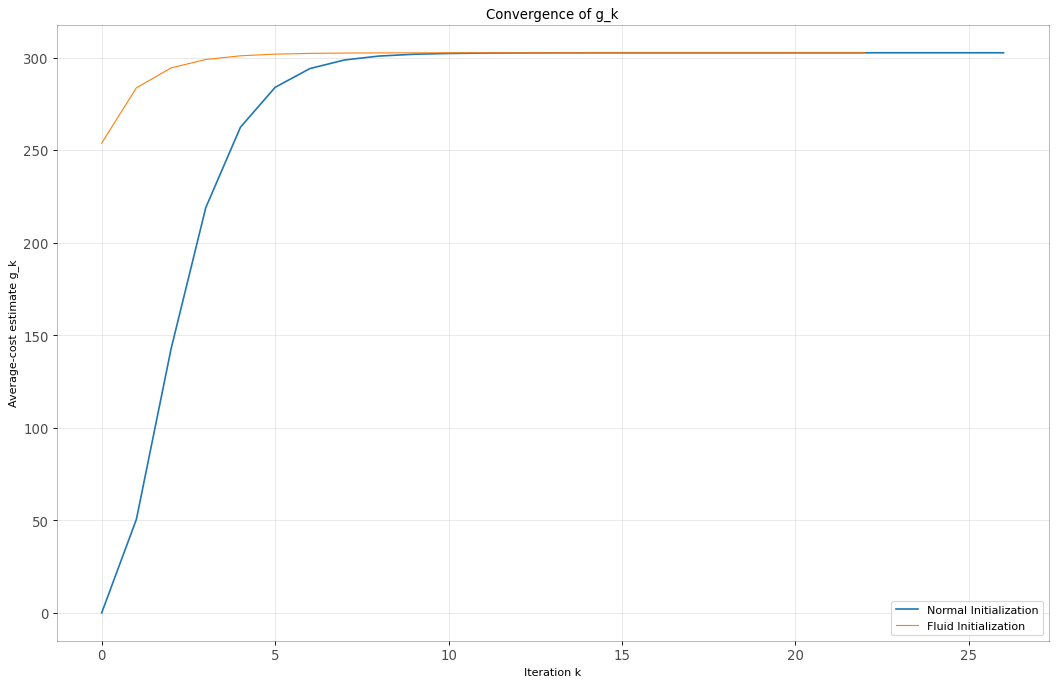

In [110]:
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(g_hist[:], marker="", fillstyle='none', label ='Normal Initialization')
plt.plot(g_hist_fluid[:], marker="", linewidth=1, label='Fluid Initialization')
plt.xlabel("Iteration k")
plt.ylabel("Average‑cost estimate g_k")
plt.title("Convergence of g_k")
plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.grid(axis='both', alpha=.3)
plt.gca().spines["top"].set_alpha(0.3)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.legend(loc = "lower right")
plt.show()